In [111]:
import os
import sys
import glob
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import math
sns.set_theme(style="whitegrid")
os.chdir('/mnt/bioadhoc-temp/Groups/vd-ay/kfetter/hichip-db-loop-calling')
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('max_colwidth', 400)

# Helper Functions

#### read fithichip loops files

In [34]:
def read_loop_files(file):
    loop_count = 0
    with open(file) as fr:
        loop_count = len(fr.readlines())
    return(loop_count)

In [35]:
# caller = 'fithichip' or 'hiccups'
# loop_type = 'chipseq.peaks', 'hichip-peaks.peaks', 'fithichip-peaks'
# config = 'L5', 'L10', 'L25', 'S5', 'S10', 'S25'
def get_loop_path(caller, loop_type, sample_name, config):
    path=''
    if caller == 'fithichip':
        if config[0] == 'L':
            path='ref_genome/results/loops/fithichip/{sn}_{lt}/{c}/FitHiChIP_Peak2ALL_b{c1}000_L20000_U2000000/P2PBckgr_0/Coverage_Bias/FitHiC_BiasCorr/FitHiChIP-{c}.interactions_FitHiC_Q0.01.bed'.format(sn = sample_name, lt = loop_type, c = config, c1 = config[1:])  
        if config[0] == 'S':
            path='ref_genome/results/loops/fithichip/{sn}_{lt}/{c}/FitHiChIP_Peak2ALL_b{c1}000_L20000_U2000000/P2PBckgr_1/Coverage_Bias/FitHiC_BiasCorr/FitHiChIP-{c}.interactions_FitHiC_Q0.01.bed'.format(sn = sample_name, lt = loop_type, c = config, c1 = config[1:])  
            
    if caller == 'hiccups':
            path = 'results/loops/hiccups/{sn}/postprocessed_pixels_{c}000.bedpe'.format(sn = sample_name, c = config)

    return(path) 

In [36]:
# caller = 'fithichip' or 'hiccups'
# loop_type = 'chipseq.peaks', 'hichip-peaks.peaks', 'fithichip-peaks'
# config = 'L5', 'L10', 'L25', 'S5', 'S10', 'S25'
def get_loop_path_hg38(caller, loop_type, sample_name, config):
    path=''
    if caller == 'fithichip':
        if config[0] == 'L':
            path='results/loops/fithichip/{sn}_{lt}/{c}/FitHiChIP_Peak2ALL_b{c1}000_L20000_U2000000/P2PBckgr_0/Coverage_Bias/FitHiC_BiasCorr/FitHiChIP-{c}.interactions_FitHiC_Q0.01.bed'.format(sn = sample_name, lt = loop_type, c = config, c1 = config[1:])  
        if config[0] == 'S':
            path='results/loops/fithichip/{sn}_{lt}/{c}/FitHiChIP_Peak2ALL_b{c1}000_L20000_U2000000/P2PBckgr_1/Coverage_Bias/FitHiC_BiasCorr/FitHiChIP-{c}.interactions_FitHiC_Q0.01.bed'.format(sn = sample_name, lt = loop_type, c = config, c1 = config[1:])  
            
    if caller == 'hiccups':
            path = 'results/loops/hiccups/{sn}/postprocessed_pixels_{c}000.bedpe'.format(sn = sample_name, c = config)

    return(path) 

#### chipseq peak files

In [37]:
def read_peaks_files(file):
    peak_count = 0
    with open(file) as fr:
        peak_count = len(fr.readlines())
    return(peak_count)

In [38]:
def get_peaks_path(sample_name, peak_type, genome):
    path=''
    if genome == "chm13":
        samplesheet = 'results/samplesheets/post-hicpro/human_t2t.peaks_files.samplesheet.without_header.tsv'
    else:
        samplesheet = 'results/samplesheets/post-hicpro/human.peaks_files.samplesheet.without_header.tsv'
        
    with open(samplesheet) as fr:
        if peak_type == 'chipseq':
            for line in fr:
                if sample_name in line:
                    info = line.strip().split()
                    path = info[4]
        if peak_type == 'fithichip':
            for line in fr:
                if sample_name in line:
                    info = line.strip().split()
                    path = info[3]
        if peak_type == 'hichip_peaks':
            for line in fr:
                if sample_name in line:
                    info = line.strip().split()
                    path = info[2]
    return(path) 

#### generate pandas dataframe 

In [39]:
## hiccups

def generate_hi_df():
    data = []
    glob_str = glob.glob('results/hicpro/*Homo*/')
    
    for fn in glob_str:
        sample_name = fn.strip().split('/')[3] 
        sample_info = []
        sample_info.append(sample_name)
        
        ## HiCCUPS
        for config in ['5', '10', '25']:
            path = get_loop_path('hiccups', 'none', sample_name, config)
            
            if os.path.exists(path) and os.stat(path).st_size != 0:
                loop_info = read_loop_files(path)
                sample_info.append(loop_info - 2)
            else:
                sample_info.append(0)
     
        data.append(sample_info)
   
    hi_df = pd.DataFrame(data)
    return hi_df

In [63]:
## fithichip, chipseq peaks

def generate_fcs_df():
    data = []
    glob_str = glob.glob('ref_genome/results/hicpro/*Homo*/')
    
    for fn in glob_str:
        sample_name = fn.strip().split('/')[3] 
        sample_info = []
        sample_info.append(sample_name)
        
        ## Chip-seq peaks chm13
        path = get_peaks_path(sample_name, 'chipseq', 'chm13')
        if os.path.exists(path):
            peak_info = read_peaks_files(path)
            sample_info.append(peak_info)
        else:
            sample_info.append('n/a')
            
        
        ## FitHiChIP Loops, chipseq chm13
                
        for config in ["S5", "L5", "S10", "L10", "S25", "L25"]:
            path = get_loop_path('fithichip', 'chipseq.peaks', sample_name, config)
            
            if os.path.exists(path) and os.stat(path).st_size != 0:
                loop_info = read_loop_files(path)
                sample_info.append(loop_info - 1)
            else:
                sample_info.append(0)
                
            
        
         ## Chip-seq peaks hg38
        path = get_peaks_path(sample_name, 'chipseq', 'hg38')
        if os.path.exists(path):
            peak_info = read_peaks_files(path)
            sample_info.append(peak_info)
        else:
            sample_info.append('n/a')
            
        
        ## FitHiChIP Loops, chipseq hg38
                
        for config in ["S5", "L5", "S10", "L10", "S25", "L25"]:
            path = get_loop_path_hg38('fithichip', 'chipseq.peaks', sample_name, config)
            
            if os.path.exists(path) and os.stat(path).st_size != 0:
                loop_info = read_loop_files(path)
                sample_info.append(loop_info - 1)
            else:
                sample_info.append(0)            
        
        data.append(sample_info)
   
    fcs_df = pd.DataFrame(data)
    return fcs_df

In [64]:
## fithichip, hichip-peaks

def generate_hp_df():
    data = []
    glob_str = glob.glob('results/hicpro/*Homo*/')
    
    for fn in glob_str:
        sample_name = fn.strip().split('/')[2] 
        sample_info = []
        sample_info.append(sample_name)                
        
         ## HP peaks
        path = get_peaks_path(sample_name, 'hichip_peaks', 'hg38')
        if os.path.exists(path):
            peak_info = read_peaks_files(path)
            sample_info.append(peak_info)
        else:
            sample_info.append(0)
            
            
        ## FitHiChIP Loops, hichip-peaks
                
        for config in ["S5", "L5", "S10", "L10", "S25", "L25"]:
            path = get_loop_path_hg38('fithichip', 'hichip-peaks.peaks', sample_name, config)
            
            if os.path.exists(path) and os.stat(path).st_size != 0:
                loop_info = read_loop_files(path)
                sample_info.append(loop_info - 1)
            else:
                sample_info.append(0)
        
        data.append(sample_info)
   
    hp_df = pd.DataFrame(data)
    return hp_df

In [65]:
## fithichip, fithichip peaks

def generate_f_df():
    data = []
    glob_str = glob.glob('ref_genome/results/hicpro/*Homo*/')
    mnase = ["VCaP-AU-4h.GSE171591.Homo_Sapiens.H3K4me4.b1", "VCaP-AU-4h.GSE171591.Homo_Sapiens.H3K27ac.b1", "VCaP-AU-4h.GSE171591.Homo_Sapiens.CTCF.b1",
             "VCaP-DMSO-4h.GSE171591.Homo_Sapiens.CTCF.b1" , "VCaP-DMSO-4h.GSE171591.Homo_Sapiens.H3K27ac.b1", "VCaP-DMSO-4h.GSE171591.Homo_Sapiens.H3K4me3.b1",
             "T47D-T0.GSE179666.Homo_Sapiens.PR.b1", "T47D-T30.GSE179666.Homo_Sapiens.PR.b1"]
    
    for fn in glob_str:
        sample_name = fn.strip().split('/')[3] 
        sample_info = []
        sample_info.append(sample_name)
        
         ## Fithichip peaks chm13
        path = get_peaks_path(sample_name, 'fithichip', 'chm13')
        if os.path.exists(path):
            peak_info = read_peaks_files(path)
            sample_info.append(peak_info)
        else:
            sample_info.append(0)
            
            
        ## FitHiChIP Loops, fithichip chm13
                
        for config in ["S5", "L5", "S10", "L10", "S25", "L25"]: #"S5", "L5", "S25", "L25"
            path = get_loop_path('fithichip', 'fithichip.peaks', sample_name, config)
            
            if os.path.exists(path) and os.stat(path).st_size != 0:
                loop_info = read_loop_files(path)
                sample_info.append(loop_info - 1)
            else:
                sample_info.append(0)
        
        ## Fithichip peaks hg38
        path = '/mnt/bioadhoc-temp/Groups/vd-ay/kfetter/hichip-db-loop-calling/results/peaks/fithichip/{s}/MACS2_ExtSize/out_macs2_peaks.narrowPeak'.format(s = sample_name)
        if os.path.exists(path):
            peak_info = read_peaks_files(path)
            sample_info.append(peak_info)
        else:
            sample_info.append(0)
            
            
        ## FitHiChIP Loops, fithichip hg38
    
        for config in ["S5", "L5", "S10", "L10", "S25", "L25"]: #"S5", "L5", "S25", "L25"
            path = get_loop_path_hg38('fithichip', 'fithichip.peaks', sample_name, config)
            
            if os.path.exists(path) and os.stat(path).st_size != 0:
                loop_info = read_loop_files(path)
                sample_info.append(loop_info - 1)
            else:
                sample_info.append(0)
        
        data.append(sample_info)
   
    f_df = pd.DataFrame(data)
    return f_df

In [66]:
def generate_df(fcs_df, hp_df, f_df):
    
    df = fcs_df.merge(hp_df)
    df = df.merge(f_df)
    return df

In [11]:
hi_df = generate_hi_df()

In [12]:
hi_df

,0,1,2,3
0,IOSE11.GSE155328.Homo_Sapiens.H3K27ac.b1,0,0,0
1,DCM_10.GSE165303.Homo_Sapiens.H3K27ac.b1,0,0,0
2,Caudate.GSE147672.Homo_Sapiens.H3K27ac.b2,0,0,0
3,Naive_Tcells.GSE101498.Homo_Sapiens.CTCF.b1,422,1252,2143
4,RERFLCAI.GSE166232.Homo_Sapiens.H3K27ac.b1,0,0,0
5,H9.GSE105028.Homo_Sapiens.NANOG.b1,0,0,0
6,Nonclassical_Monocyte_1814.phs001703v4p1.Homo_Sapiens.H3K27ac.b3,0,0,0
7,HEC-1-B-WT.GSE148958.Homo_Sapiens.V5.b1,0,0,0
8,DCM_7.GSE165303.Homo_Sapiens.H3K27ac.b1,0,0,0
9,cbCD34+-HSPC-SJALL068279-D1.GSE165207.Homo_Sapiens.H3K27ac.b1,4583,6602,5964


In [67]:
fcs_df = generate_fcs_df()

In [68]:
columns = ["sample_name", "chm13 Number Peaks, ChIP-seq", "chm13 Number Loops, S5", "chm13 Number Loops, L5", "chm13 Number Loops, S10", "chm13 Number Loops, L10", "chm13 Number Loops, S25", "chm13 Number Loops, L25", "hg38 Number Peaks, ChIP-seq", "hg38 Number Loops, S5", "hg38 Number Loops, L5", "hg38 Number Loops, S10", "hg38 Number Loops, L10", "hg38 Number Loops, S25", "hg38 Number Loops, L25"]
fcs_df.columns = columns
fcs_df.sort_values(by="sample_name")

,sample_name,"chm13 Number Peaks, ChIP-seq","chm13 Number Loops, S5","chm13 Number Loops, L5","chm13 Number Loops, S10","chm13 Number Loops, L10","chm13 Number Loops, S25","chm13 Number Loops, L25","hg38 Number Peaks, ChIP-seq","hg38 Number Loops, S5","hg38 Number Loops, L5","hg38 Number Loops, S10","hg38 Number Loops, L10","hg38 Number Loops, S25","hg38 Number Loops, L25"
120,293T-PDS.GSE128106.Homo_Sapiens.YY1.b1,17033,0,0,0,0,0,0,19491,0,0,0,0,0,0
153,293T-TMPYP4.GSE128106.Homo_Sapiens.YY1.b1,17486,0,0,1,1,4,4,21727,0,0,0,0,0,3
482,293T.GSE128106.Homo_Sapiens.YY1.b1,20460,0,0,0,0,0,0,21267,0,0,0,0,0,0
13,A673-siCT-Dh1-72h-D347-D362.GSE156650.Homo_Sapiens.CTCF.b1,115054,175,412,2848,6413,30386,55050,115154,177,393,2800,6010,30157,51884
413,A673-siCT-Dh1-72h-D347-D362.GSE156650.Homo_Sapiens.CTCF.b2,115054,33,70,653,1470,9241,17885,115154,35,65,570,1284,9008,16829
430,A673-siSA2-Dh6-72h-D347-D362.GSE156650.Homo_Sapiens.CTCF.b1,102853,15,23,788,1797,22291,41445,102935,11,23,734,1745,22242,39397
193,A673-siSA2-Dh6-72h-D347-D362.GSE156650.Homo_Sapiens.CTCF.b2,102853,2,4,118,274,6933,14612,102935,3,7,123,295,7040,13616
259,A673-siSA2-Dh8-72h-D347-D362.GSE156650.Homo_Sapiens.CTCF.b1,104080,0,0,53,113,8664,15713,104318,3,3,56,93,8455,14863
218,A673-siSA2-Dh8-72h-D347-D362.GSE156650.Homo_Sapiens.CTCF.b2,104080,0,0,8,27,3588,7056,104318,4,4,10,17,3662,6444
233,A673_SA1m1.GSE133227.Homo_Sapiens.CTCF.b1,n/a,0,0,0,0,0,0,n/a,0,0,0,0,0,0


In [19]:
hp_df = generate_hp_df()

In [20]:
hp_df.sort_values(by=0)

,0,1,2,3,4,5,6,7
450,293T-PDS.GSE128106.Homo_Sapiens.YY1.b1,968,0,0,0,0,0,0
310,293T-TMPYP4.GSE128106.Homo_Sapiens.YY1.b1,1801,0,0,0,0,2,2
151,293T.GSE128106.Homo_Sapiens.YY1.b1,43,0,0,0,0,238,2
266,A673-siCT-Dh1-72h-D347-D362.GSE156650.Homo_Sapiens.CTCF.b1,3468,31,349,412,2696,2533,9825
318,A673-siCT-Dh1-72h-D347-D362.GSE156650.Homo_Sapiens.CTCF.b2,3468,6,80,123,994,1328,5859
307,A673-siSA2-Dh6-72h-D347-D362.GSE156650.Homo_Sapiens.CTCF.b1,2205,3,30,50,530,703,2944
220,A673-siSA2-Dh6-72h-D347-D362.GSE156650.Homo_Sapiens.CTCF.b2,2205,3,8,38,227,672,3195
13,A673-siSA2-Dh8-72h-D347-D362.GSE156650.Homo_Sapiens.CTCF.b1,46,0,2,0,21,0,121
207,A673-siSA2-Dh8-72h-D347-D362.GSE156650.Homo_Sapiens.CTCF.b2,46,0,2,0,6,0,61
143,A673_SA1m1.GSE133227.Homo_Sapiens.CTCF.b1,29585,3747,12292,10675,35490,25651,69659


In [71]:
f_df = generate_f_df()

In [72]:
columns = ["sample_name", "chm13 Number Peaks, ChIP-seq", "chm13 Number Loops, S5", "chm13 Number Loops, L5", "chm13 Number Loops, S10", "chm13 Number Loops, L10", "chm13 Number Loops, S25", "chm13 Number Loops, L25", "hg38 Number Peaks, ChIP-seq", "hg38 Number Loops, S5", "hg38 Number Loops, L5", "hg38 Number Loops, S10", "hg38 Number Loops, L10", "hg38 Number Loops, S25", "hg38 Number Loops, L25"]
f_df.columns = columns
f_df.sort_values(by="sample_name").reset_index(drop=True)

,sample_name,"chm13 Number Peaks, ChIP-seq","chm13 Number Loops, S5","chm13 Number Loops, L5","chm13 Number Loops, S10","chm13 Number Loops, L10","chm13 Number Loops, S25","chm13 Number Loops, L25","hg38 Number Peaks, ChIP-seq","hg38 Number Loops, S5","hg38 Number Loops, L5","hg38 Number Loops, S10","hg38 Number Loops, L10","hg38 Number Loops, S25","hg38 Number Loops, L25"
0,293T-PDS.GSE128106.Homo_Sapiens.YY1.b1,29904,0,0,0,0,0,0,29430,0,0,0,0,0,0
1,293T-TMPYP4.GSE128106.Homo_Sapiens.YY1.b1,74311,0,0,1,1,2,5,73184,0,0,0,0,3,5
2,293T.GSE128106.Homo_Sapiens.YY1.b1,1003,0,0,0,0,0,0,987,0,0,0,0,0,0
3,A673-siCT-Dh1-72h-D347-D362.GSE156650.Homo_Sapiens.CTCF.b1,10285,36,351,717,3976,7981,25143,11489,47,346,776,3989,8323,24510
4,A673-siCT-Dh1-72h-D347-D362.GSE156650.Homo_Sapiens.CTCF.b2,10285,11,61,159,1137,2490,9655,10428,7,58,148,990,2518,9413
5,A673-siSA2-Dh6-72h-D347-D362.GSE156650.Homo_Sapiens.CTCF.b1,23178,4,18,184,1189,4518,15386,7761,4,29,186,1111,4839,15127
6,A673-siSA2-Dh6-72h-D347-D362.GSE156650.Homo_Sapiens.CTCF.b2,23178,2,4,61,242,3638,9836,23228,3,6,71,260,3720,9577
7,A673-siSA2-Dh8-72h-D347-D362.GSE156650.Homo_Sapiens.CTCF.b1,27647,0,2,23,79,2564,5744,9018,3,4,39,94,2688,5674
8,A673-siSA2-Dh8-72h-D347-D362.GSE156650.Homo_Sapiens.CTCF.b2,27647,0,0,5,18,2290,4374,27484,5,5,16,23,2398,4350
9,A673_SA1m1.GSE133227.Homo_Sapiens.CTCF.b1,60043,3551,11741,11407,35771,33349,81467,60295,3514,11200,11313,34768,33321,79208


In [31]:
#hi_df.columns = ['sample_name', "Hi.5", "Hi.10", "Hi.25"]
fcs_df.columns = ['sample_name', "CP", "FCP.S5", "FCP.L5", "FCP.S10", "FCP.L10", "FCP.S25", "FCP.L25"]
hp_df.columns = ['sample_name', "HPP", "FHPP.S5", "FHPP.L5", "FHPP.S10", "FHPP.L10", "FHPP.S25", "FHPP.L25"]
f_df.columns = ['sample_name', "F", "FF.S5", "FF.L5", "FF.S10", "FF.L10", "FF.S25", "FF.L25"]

#hi_df = hi_df.sort_values(by='sample_name').reset_index(drop=True)
fcs_df = fcs_df.sort_values(by='sample_name').reset_index(drop=True)
hp_df = hp_df.sort_values(by='sample_name').reset_index(drop=True)
f_df = f_df.sort_values(by='sample_name').reset_index(drop=True)

df = generate_df(fcs_df, hp_df, f_df)
df = df.sort_values(by='sample_name').reset_index(drop=True)
df

,sample_name,CP,FCP.S5,FCP.L5,FCP.S10,FCP.L10,FCP.S25,FCP.L25,HPP,FHPP.S5,FHPP.L5,FHPP.S10,FHPP.L10,FHPP.S25,FHPP.L25,F,FF.S5,FF.L5,FF.S10,FF.L10,FF.S25,FF.L25
0,293T-PDS.GSE128106.Homo_Sapiens.YY1.b1,19491,0,0,0,0,0,0,968,0,0,0,0,0,0,29430,0,0,0,0,0,0
1,293T-TMPYP4.GSE128106.Homo_Sapiens.YY1.b1,21727,0,0,0,0,0,3,1801,0,0,0,0,2,2,73184,0,0,0,0,3,5
2,293T.GSE128106.Homo_Sapiens.YY1.b1,21267,0,0,0,0,0,0,43,0,0,0,0,238,2,987,0,0,0,0,0,0
3,A673-siCT-Dh1-72h-D347-D362.GSE156650.Homo_Sapiens.CTCF.b1,115154,177,393,2800,6010,30157,51884,3468,31,349,412,2696,2533,9825,11489,47,346,776,3989,8323,24510
4,A673-siCT-Dh1-72h-D347-D362.GSE156650.Homo_Sapiens.CTCF.b2,115154,35,65,570,1284,9008,16829,3468,6,80,123,994,1328,5859,10428,7,58,148,990,2518,9413
5,A673-siSA2-Dh6-72h-D347-D362.GSE156650.Homo_Sapiens.CTCF.b1,102935,11,23,734,1745,22242,39397,2205,3,30,50,530,703,2944,7761,4,29,186,1111,4839,15127
6,A673-siSA2-Dh6-72h-D347-D362.GSE156650.Homo_Sapiens.CTCF.b2,102935,3,7,123,295,7040,13616,2205,3,8,38,227,672,3195,23228,3,6,71,260,3720,9577
7,A673-siSA2-Dh8-72h-D347-D362.GSE156650.Homo_Sapiens.CTCF.b1,104318,3,3,56,93,8455,14863,46,0,2,0,21,0,121,9018,3,4,39,94,2688,5674
8,A673-siSA2-Dh8-72h-D347-D362.GSE156650.Homo_Sapiens.CTCF.b2,104318,4,4,10,17,3662,6444,46,0,2,0,6,0,61,27484,5,5,16,23,2398,4350
9,A673_SA1m1.GSE133227.Homo_Sapiens.CTCF.b1,n/a,0,0,0,0,0,0,29585,3747,12292,10675,35490,25651,69659,60295,3514,11200,11313,34768,33321,79208


In [32]:
df.to_excel("human_loops_1_30_23.xlsx")

In [17]:
df_copy = df.copy(deep=True)

In [18]:
hi_df_copy = hi_df.copy(deep=True)
fcs_df_copy = fcs_df.copy(deep=True)
hp_df_copy = hp_df.copy(deep=True)
f_df_copy = f_df.copy(deep=True)

In [19]:
def set_status(row):
    if row['CP'] != 'n/a' and row['CP'] > 1000:
          return 1
    return 0

In [20]:
fcs_df_copy['Status'] = fcs_df_copy.apply(lambda row: set_status(row), axis=1)
fcs_df_copy = fcs_df_copy.loc[fcs_df_copy["Status"] == 1].reset_index(drop=True)
fcs_df_copy

,sample_name,CP,FCP.S5,FCP.L5,FCP.S10,FCP.L10,FCP.S25,FCP.L25,Status
0,293T-PDS.GSE128106.Homo_Sapiens.YY1.b1,19491,0,0,0,0,0,0,1
1,293T-TMPYP4.GSE128106.Homo_Sapiens.YY1.b1,21727,0,0,0,0,0,3,1
2,293T.GSE128106.Homo_Sapiens.YY1.b1,21267,0,0,0,0,0,0,1
3,Aortic-VIC.GSE154513.Homo_Sapiens.H3K27ac.b1,163779,12786,53896,28571,110387,64184,158929,1
4,BC1.GSE136090.Homo_Sapiens.H3K27ac.b1,13670,31,37,91,164,554,1343,1
5,BC3.GSE136090.Homo_Sapiens.H3K27ac.b1,12866,0,0,8,14,221,657,1
6,BCBL1.GSE136090.Homo_Sapiens.H3K27ac.b1,18843,519,1005,1129,3300,3293,10846,1
7,CD34+-Cord-Blood.GSE165207.Homo_Sapiens.H3K27ac.b1,130219,40515,146863,75629,226532,133443,282327,1
8,CD4_Naive_1800-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b1,85359,0,0,0,0,0,0,1
9,CD4_Naive_1800-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b2,85359,0,0,0,0,0,0,1


In [21]:
fcs_df_copy.describe()

,FCP.S5,FCP.L5,FCP.S10,FCP.L10,FCP.S25,FCP.L25,Status
count,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.0
mean,5928.182979,17667.191489,8227.370213,23736.919149,14956.910638,32431.148936,1.0
std,19924.034254,50375.811092,27222.462503,62388.120705,40736.114881,70687.564350,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
75%,328.000000,787.000000,2108.500000,5571.500000,11514.500000,34558.500000,1.0
max,158091.000000,366779.000000,224772.000000,374924.000000,360056.000000,452160.000000,1.0


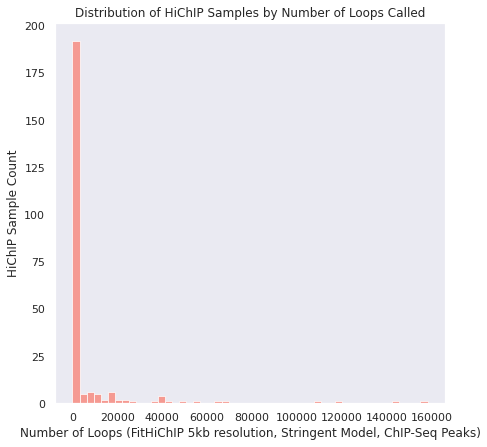

In [22]:
sns.set(rc = {'figure.figsize':(7,7)})
sns.set_theme(style="dark")
palette = [
'#fa8072',
'#90AACB',
'#9F5F80']
sns.set_palette(palette)
ax = sns.histplot(x="FCP.S5", data=fcs_df_copy, bins=50)
ax.set(xlabel='Number of Loops (FitHiChIP 5kb resolution, Stringent Model, ChIP-Seq Peaks)', ylabel='HiChIP Sample Count', title='Distribution of HiChIP Samples by Number of Loops Called')
fig = ax.get_figure()
fig.savefig('dist-num-loops-5kb.png', dpi=300) 

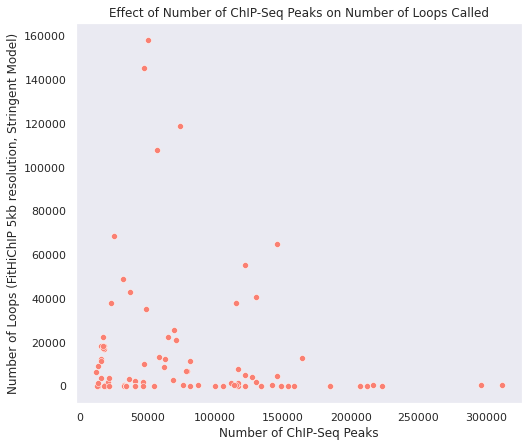

In [130]:
sns.set(rc = {'figure.figsize':(8,7)})
sns.set_theme(style="dark")
palette = [
'#fa8072',
'#90AACB',
'#9F5F80']
sns.set_palette(palette)
ax = sns.scatterplot(x="CP",y="FCP.S5", data=fcs_df_copy)
ax.set(ylabel='Number of Loops (FitHiChIP 5kb resolution, Stringent Model)', xlabel='Number of ChIP-Seq Peaks', title='Effect of Number of ChIP-Seq Peaks on Number of Loops Called')
fig = ax.get_figure()
fig.savefig('dist-loops-peaks.png', dpi=300) 

In [103]:
def read_hicpro_stats_log(log):
    log_data = 'check'
    with open(log) as fr:
        for line in fr:
            if line.strip().split()[0] == 'valid_interaction':
                info = line.strip().split()
                log_data = int(info[1])
    return(log_data)

In [111]:
mRSstat_data = []
tpl = 'results/hicpro/{std_sample_name}/hic_results/stats/{std_sample_name}/{std_sample_name}_allValidPairs.mergestat'
glob_str = tpl.format(std_sample_name='*')
for fn in glob.glob(glob_str):
    data = []
    std_sample_name = fn.split('/')[2]
    data.append(std_sample_name)
    mRSstat = read_hicpro_stats_log(fn)
    data.append(mRSstat)
    mRSstat_data.append(data)
mRSstat_df = pd.DataFrame(mRSstat_data)
columns = ['sample_name', 'valid_pairs']
mRSstat_df.columns = columns

In [120]:
fcs_df_copy_1 = fcs_df_copy.copy(deep=True)
fcs_df_copy_1 = fcs_df_copy_1.merge(mRSstat_df)

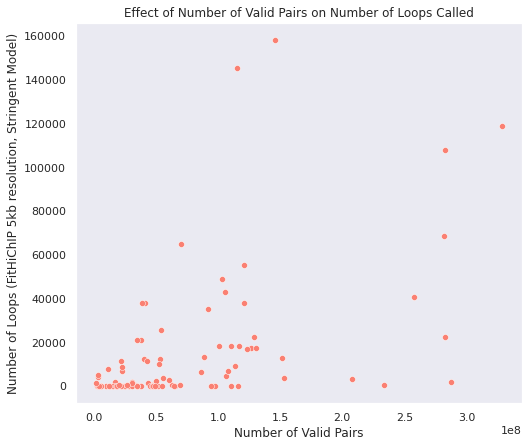

In [129]:
sns.set(rc = {'figure.figsize':(8,7)})
sns.set_theme(style="dark")
palette = [
'#fa8072',
'#90AACB',
'#9F5F80']
sns.set_palette(palette)
ax = sns.scatterplot(x="valid_pairs",y="FCP.S5", data=fcs_df_copy_1)
ax.set(ylabel='Number of Loops (FitHiChIP 5kb resolution, Stringent Model)', xlabel='Number of Valid Pairs', title='Effect of Number of Valid Pairs on Number of Loops Called')
fig = ax.get_figure()
fig.savefig('dist-loops-validpairs.png', dpi=300) 

In [145]:
def read_loop_files_dist(file):
    loops_dists = []
    with open(file) as fr:
        next(fr)
        for line in fr:
            info = line.strip().split()
            loops_dists.append(int(info[4]) - int(info[1]))
    return loops_dists

In [149]:
file = '/mnt/BioAdHoc/Groups/vd-ay/kfetter/hichip-db-loop-calling/results/loops/fithichip/Aortic-VIC.GSE154513.Homo_Sapiens.H3K27ac.b1_chipseq.peaks/S5/FitHiChIP_Peak2ALL_b5000_L20000_U2000000/P2PBckgr_1/Coverage_Bias/FitHiC_BiasCorr/FitHiChIP-S5.interactions_FitHiC_Q0.01.bed'
dists = read_loop_files_dist(file)

In [152]:
dists_df = pd.DataFrame(dists)
dists_df.describe()

,0
count,1.278600e+04
mean,2.185891e+05
std,2.136933e+05
min,2.000000e+04
25%,8.500000e+04
50%,1.500000e+05
75%,2.800000e+05
max,1.990000e+06


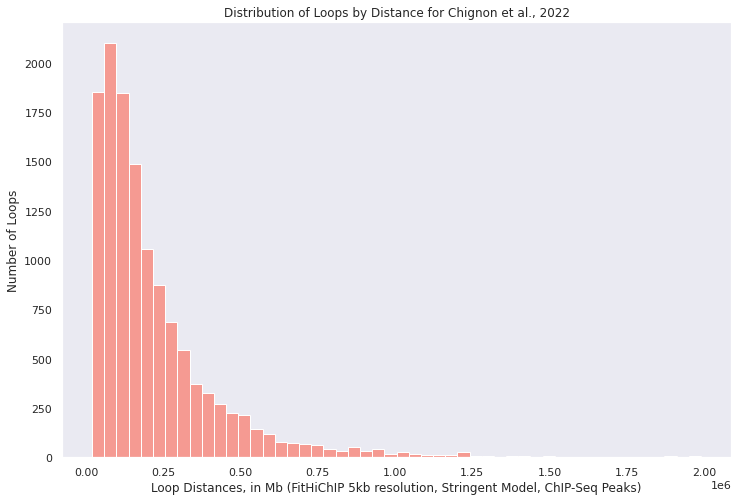

In [160]:
sns.set(rc = {'figure.figsize':(12,8)})
sns.set_theme(style="dark")
palette = [
'#fa8072',
'#90AACB',
'#9F5F80']
sns.set_palette(palette)
ax = sns.histplot(x=0, data=dists_df, bins=50)
ax.set(xlabel='Loop Distances, in Mb (FitHiChIP 5kb resolution, Stringent Model, ChIP-Seq Peaks)', ylabel='Number of Loops', title='Distribution of Loops by Distance for Chignon et al., 2022')
fig = ax.get_figure()
fig.savefig('dist-loops-dist-5kb.png', dpi=300) 

## T2T and hg38 Fold Change

In [73]:
fcs_df.loc[fcs_df["chm13 Number Peaks, ChIP-seq"] == "n/a" and fcs_df["hg38 Number Peaks, ChIP-seq"] != "n/a"]

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [85]:
valid_fcs_df = fcs_df.loc[(fcs_df["chm13 Number Peaks, ChIP-seq"] != "n/a")]
cols = ["sample_name", "chm13_peaks", "chm13_s5", "chm13_l5", "chm13_s10", "chm13_l10", "chm13_s25", "chm13_l25", "hg38_peaks", "hg38_s5", "hg38_l5", "hg38_s10", "hg38_l10", "hg38_s25", "hg38_l25"]
valid_fcs_df.columns = cols
valid_fcs_df

,sample_name,chm13_peaks,chm13_s5,chm13_l5,chm13_s10,chm13_l10,chm13_s25,chm13_l25,hg38_peaks,hg38_s5,hg38_l5,hg38_s10,hg38_l10,hg38_s25,hg38_l25
0,Nonclassical_Monocyte_1800.phs001703v4p1.Homo_Sapiens.H3K27ac.b2,198329,2159,4820,3950,11631,8259,21917,169621,1865,4665,3512,11338,7868,22124
1,HeLa-S3-shBHLHE40.GSE137849.Homo_Sapiens.CTCF.b1,27629,981,931,3584,3652,12764,15935,32921,367,887,1652,3935,7911,17299
2,Naive_B_1816-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b3,260427,3206,4221,6095,9209,6864,12931,260797,3246,4149,6341,9274,6955,12846
4,Monocyte_1831-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b3,122299,2037,5201,3414,11726,4152,18173,122506,1973,5081,3497,11487,4055,17697
6,Naive_B_1815-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b3,260427,1245,1671,2797,4640,3536,8177,260797,1183,1642,2793,4729,3550,8112
11,Hela-S3-OE.GSE108869.Homo_Sapiens.CTCF.b2,148106,71,105,3578,5468,51385,66258,148577,81,103,3745,5398,52251,64161
12,Naive_B_1814-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b2,260427,6133,10965,8008,19916,12980,31618,260797,5882,10614,8096,19257,12917,30673
13,A673-siCT-Dh1-72h-D347-D362.GSE156650.Homo_Sapiens.CTCF.b1,115054,175,412,2848,6413,30386,55050,115154,177,393,2800,6010,30157,51884
14,THP-1-del-cIDR.GSE149420.Homo_Sapiens.H3K27ac.b1,11772,51193,68455,34038,61716,24107,53542,13491,9149,46164,8843,47980,9085,46720
15,NF_1.GSE165303.Homo_Sapiens.H3K27ac.b1,132432,1095,2009,6728,14298,29411,57005,132375,1062,1911,6622,13775,29735,55843


In [101]:
def fold_change(chm13_value, hg38_value):
    if (hg38_value == 0 or chm13_value == 0):
        return "N/A"
    return math.log((chm13_value / hg38_value), 2)

In [102]:
valid_fcs_df['peaks_fold_change'] = valid_fcs_df.apply(lambda x: fold_change(x.chm13_peaks, x.hg38_peaks), axis=1)
valid_fcs_df['s5_fold_change'] = valid_fcs_df.apply(lambda x: fold_change(x.chm13_s5, x.hg38_s5), axis=1)
valid_fcs_df['l5_fold_change'] = valid_fcs_df.apply(lambda x: fold_change(x.chm13_l5, x.hg38_l5), axis=1)
valid_fcs_df['s10_fold_change'] = valid_fcs_df.apply(lambda x: fold_change(x.chm13_s10, x.hg38_s10), axis=1)
valid_fcs_df['l10_fold_change'] = valid_fcs_df.apply(lambda x: fold_change(x.chm13_l10, x.hg38_l10), axis=1)
valid_fcs_df['s25_fold_change'] = valid_fcs_df.apply(lambda x: fold_change(x.chm13_s25, x.hg38_s25), axis=1)
valid_fcs_df['l25_fold_change'] = valid_fcs_df.apply(lambda x: fold_change(x.chm13_l25, x.hg38_l25), axis=1)

/tmp/ipykernel_84468/2591117844.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_fcs_df['peaks_fold_change'] = valid_fcs_df.apply(lambda x: fold_change(x.chm13_peaks, x.hg38_peaks), axis=1)
/tmp/ipykernel_84468/2591117844.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_fcs_df['s5_fold_change'] = valid_fcs_df.apply(lambda x: fold_change(x.chm13_s5, x.hg38_s5), axis=1)
/tmp/ipykernel_84468/2591117844.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

In [103]:
valid_fcs_df

,sample_name,chm13_peaks,chm13_s5,chm13_l5,chm13_s10,chm13_l10,chm13_s25,chm13_l25,hg38_peaks,hg38_s5,hg38_l5,hg38_s10,hg38_l10,hg38_s25,hg38_l25,Fold Change Peaks,peaks_fold_change,s5_fold_change,l5_fold_change,s10_fold_change,l10_fold_change,s25_fold_change,l25_fold_change
0,Nonclassical_Monocyte_1800.phs001703v4p1.Homo_Sapiens.H3K27ac.b2,198329,2159,4820,3950,11631,8259,21917,169621,1865,4665,3512,11338,7868,22124,0.225581,0.225581,0.211188,0.047156,0.16956,0.036809,0.06997,-0.013562
1,HeLa-S3-shBHLHE40.GSE137849.Homo_Sapiens.CTCF.b1,27629,981,931,3584,3652,12764,15935,32921,367,887,1652,3935,7911,17299,-0.252825,-0.252825,1.418473,0.069847,1.117357,-0.107677,0.690149,-0.11849
2,Naive_B_1816-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b3,260427,3206,4221,6095,9209,6864,12931,260797,3246,4149,6341,9274,6955,12846,-0.002048,-0.002048,-0.017889,0.024821,-0.057084,-0.010147,-0.019001,0.009515
4,Monocyte_1831-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b3,122299,2037,5201,3414,11726,4152,18173,122506,1973,5081,3497,11487,4055,17697,-0.002440,-0.002440,0.046055,0.033677,-0.034655,0.029709,0.034105,0.038292
6,Naive_B_1815-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b3,260427,1245,1671,2797,4640,3536,8177,260797,1183,1642,2793,4729,3550,8112,-0.002048,-0.002048,0.073696,0.025258,0.002065,-0.02741,-0.005701,0.011514
11,Hela-S3-OE.GSE108869.Homo_Sapiens.CTCF.b2,148106,71,105,3578,5468,51385,66258,148577,81,103,3745,5398,52251,64161,-0.004581,-0.004581,-0.190103,0.027745,-0.065812,0.018588,-0.024111,0.046398
12,Naive_B_1814-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b2,260427,6133,10965,8008,19916,12980,31618,260797,5882,10614,8096,19257,12917,30673,-0.002048,-0.002048,0.060286,0.046937,-0.015767,0.048545,0.007019,0.043777
13,A673-siCT-Dh1-72h-D347-D362.GSE156650.Homo_Sapiens.CTCF.b1,115054,175,412,2848,6413,30386,55050,115154,177,393,2800,6010,30157,51884,-0.001253,-0.001253,-0.016394,0.068115,0.024522,0.093634,0.010914,0.085453
14,THP-1-del-cIDR.GSE149420.Homo_Sapiens.H3K27ac.b1,11772,51193,68455,34038,61716,24107,53542,13491,9149,46164,8843,47980,9085,46720,-0.196638,-0.196638,2.484261,0.568388,1.944538,0.363211,1.407894,0.196631
15,NF_1.GSE165303.Homo_Sapiens.H3K27ac.b1,132432,1095,2009,6728,14298,29411,57005,132375,1062,1911,6622,13775,29735,55843,0.000621,0.000621,0.044147,0.07215,0.022911,0.053761,-0.015806,0.029712


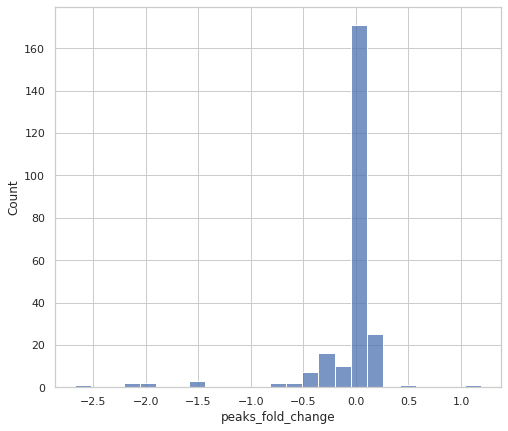

In [115]:
ax = sns.histplot(x="peaks_fold_change", data=valid_fcs_df, bins=25)
#ax.set(ylabel='Number of Loops (FitHiChIP 5kb resolution, Stringent Model)', xlabel='Number of ChIP-Seq Peaks', title='Effect of Number of ChIP-Seq Peaks on Number of Loops Called')

ValueError: Unable to parse string "N/A" at position 21

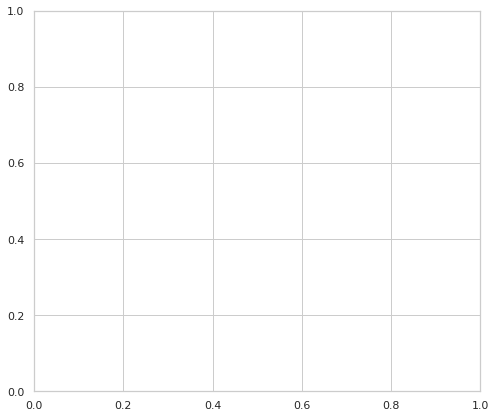

In [117]:
valid_fcs_df.loc[]
ax = sns.histplot(x="s10_fold_change", data=valid_fcs_df, bins=25)